In [1]:
import torch
from numpy.random import default_rng
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import numpy as np

In [2]:
training_data = datasets.FashionMNIST(root="data",
                                      train=True,
                                      download=True,
                                      transform=ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                      train=False,
                                      download=True,
                                      transform=ToTensor())

Ankle boot


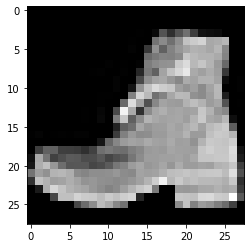

In [3]:
# Run this to explore random data

rng = default_rng()
slct = rng.integers(training_data.data.shape[0])

plt.imshow(training_data.data[slct], cmap='gray');
print(training_data.classes[training_data.targets[slct]])

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# This is written this way to show the form of the loop.
# X is a batch of data
# y is the labels for the data
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Verify that cuda is available
torch.cuda.is_available()

True

In [6]:
device = "cuda"  # If cuda is available!

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)  
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # Stochastic Gradient Descent

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#        if batch % 100 == 0:
#            loss, current = loss.item(), batch * len(X)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")          

In [9]:
[x.shape for x in model.parameters()]

[torch.Size([512, 784]),
 torch.Size([512]),
 torch.Size([512, 512]),
 torch.Size([512]),
 torch.Size([10, 512]),
 torch.Size([10])]

In [10]:
# This ran at about 7s per epoch

epochs = 15
for t in trange(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 49.8%, Avg loss: 2.144609 

Test Error: 
 Accuracy: 55.4%, Avg loss: 1.856448 

Test Error: 
 Accuracy: 59.5%, Avg loss: 1.485078 

Test Error: 
 Accuracy: 62.6%, Avg loss: 1.229332 

Test Error: 
 Accuracy: 64.5%, Avg loss: 1.072541 

Test Error: 
 Accuracy: 66.1%, Avg loss: 0.971241 

Test Error: 
 Accuracy: 67.7%, Avg loss: 0.901497 

Test Error: 
 Accuracy: 69.1%, Avg loss: 0.850667 

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.811700 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.780499 

Test Error: 
 Accuracy: 72.8%, Avg loss: 0.754509 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.732142 

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.712403 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.694650 

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.678503 



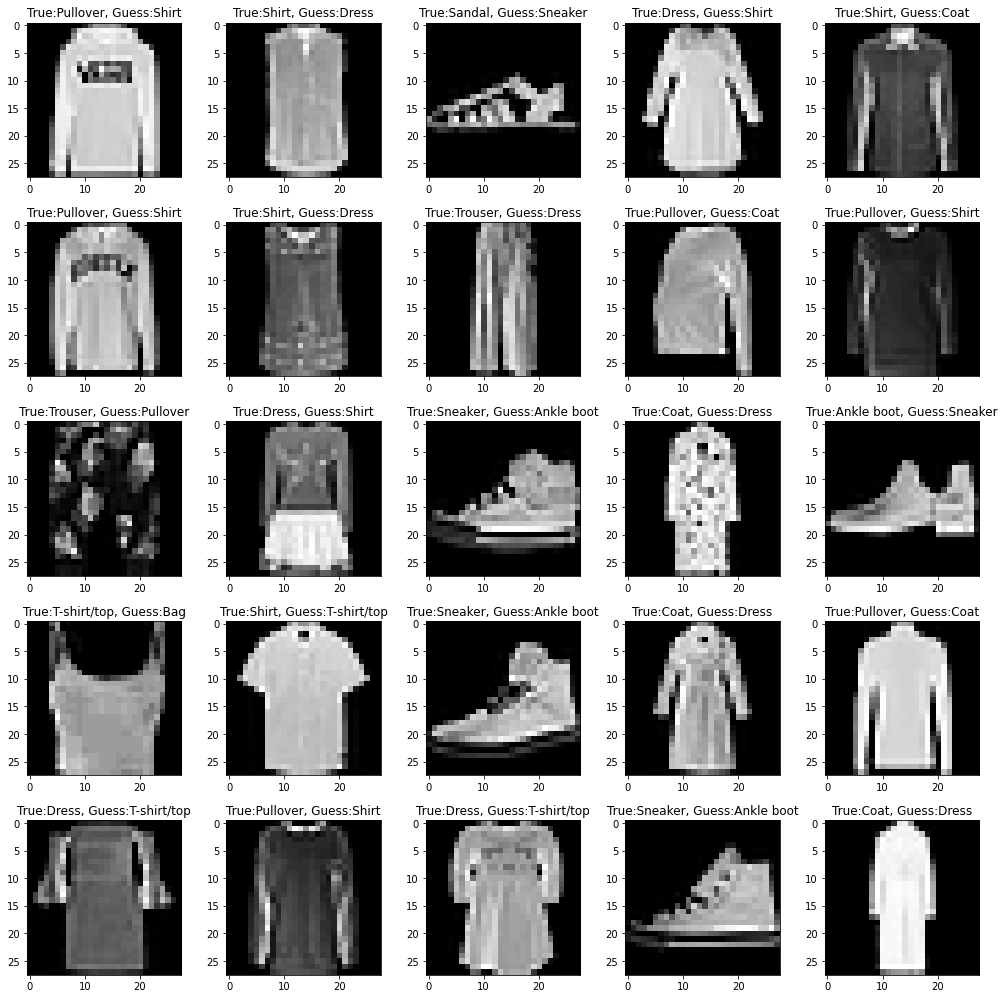

In [11]:
# Run this to explore random wrong answers
@torch.no_grad()
def explore_wrong_5x5(dataloader, model, device, class_labels=None, seed=None):
    rng = default_rng(seed)
    all_wrong = torch.empty(0, dtype=torch.int64, device=device)
    preds = torch.empty(0, dtype=torch.int64, device=device)
    gtruths = torch.empty(0, dtype=torch.int64, device=device)
    for X, y in dataloader:
        X = X.to(device)
        pred = model(X).argmax(1)
        y = y.to(device)
        wrong = pred != y
        wrong_ixs = torch.argwhere(wrong).flatten()
        for ix in wrong_ixs:
            all_wrong = torch.cat((all_wrong, X[ix, ...]))
            preds = torch.cat((preds, torch.tensor([pred[ix]]).to(device)))
            gtruths = torch.cat((gtruths, torch.tensor([y[ix]]).to(device)))
    
    example_ixs = rng.choice(range(len(gtruths)), 25, replace=False)
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    fig.tight_layout()
    for i, ix in enumerate(example_ixs):
        X = all_wrong[ix]
        y = gtruths[ix]
        y_guess = preds[ix]
        if class_labels:
            true = class_labels[y]
            guess = class_labels[y_guess]
        else:
            true = str(y)
            guess = str(y_guess)
        ax = axes.flatten()[i]
        ax.set_title(f'True:{true}, Guess:{guess}')
        im = X.squeeze().cpu()
        ax.imshow(im, cmap='gray')
    
    
explore_wrong_5x5(train_dataloader, model, device, class_labels=training_data.classes, seed=90210)

In [12]:
# Define model
class CNeuralNetwork(nn.Module):
    def __init__(self):
        super(CNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(16, 256, 3, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(),
            nn.Conv2d(256, 512, 7, stride=1, padding=1, padding_mode='reflect'),
            nn.MaxPool2d(3),
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model2 = CNeuralNetwork().to(device)  
print(model2)

CNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): Conv2d(16, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): ReLU()
    (4): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
# This ran about 17s per epoch

optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)  # Stochastic Gradient Descent

epochs = 15
for t in trange(epochs):
    train(train_dataloader, model2, loss_fn, optimizer)
    test(test_dataloader, model2, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 11.0%, Avg loss: 2.298142 

Test Error: 
 Accuracy: 32.8%, Avg loss: 2.292928 

Test Error: 
 Accuracy: 38.4%, Avg loss: 2.284852 

Test Error: 
 Accuracy: 43.9%, Avg loss: 2.269800 

Test Error: 
 Accuracy: 53.1%, Avg loss: 2.236034 

Test Error: 
 Accuracy: 49.9%, Avg loss: 2.124191 

Test Error: 
 Accuracy: 49.5%, Avg loss: 1.627809 

Test Error: 
 Accuracy: 62.3%, Avg loss: 1.127614 

Test Error: 
 Accuracy: 67.5%, Avg loss: 0.931849 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.828402 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.758377 

Test Error: 
 Accuracy: 74.9%, Avg loss: 0.711733 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.680699 

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.658188 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.640284 



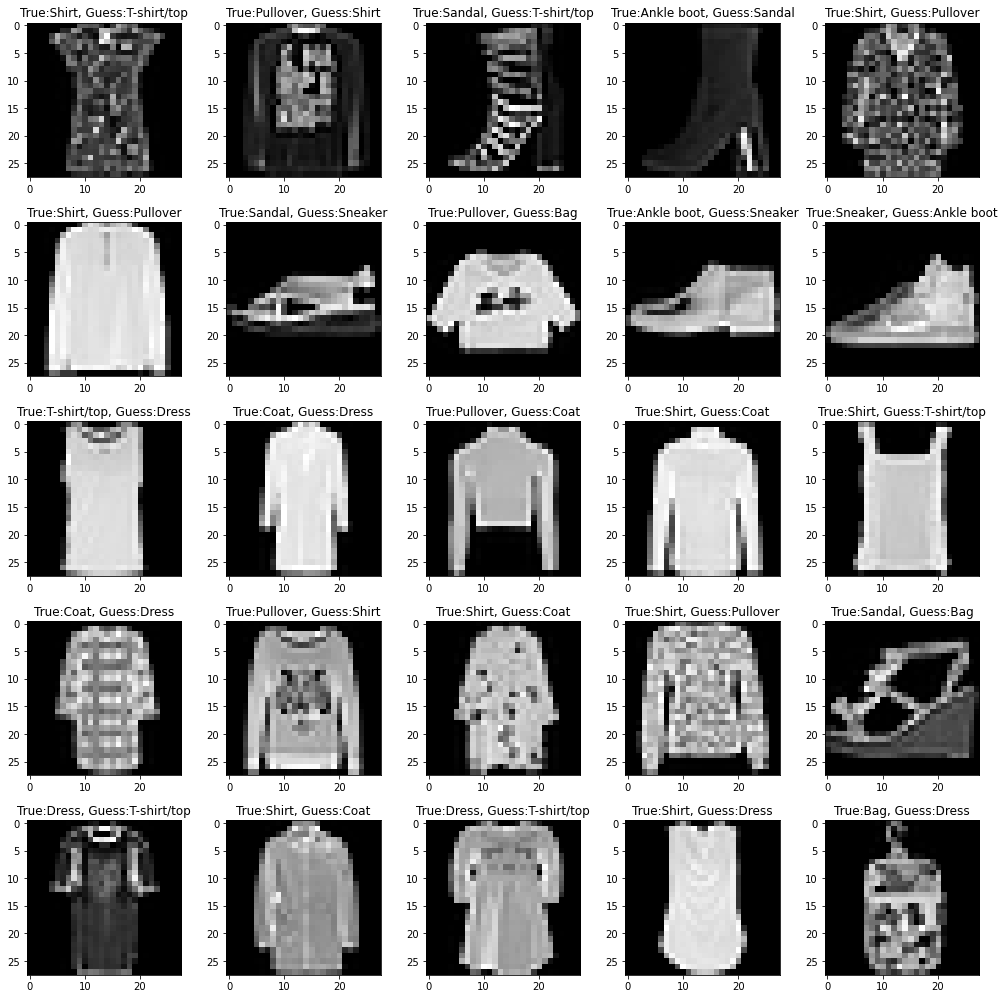

In [14]:
explore_wrong_5x5(train_dataloader, model2, device, class_labels=training_data.classes, seed=90210)

In [16]:
torch.save(model2, 'models/mycnn')

In [17]:
model3 = torch.load('models/mycnn')
print(model3)

CNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): Conv2d(16, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): ReLU()
    (4): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


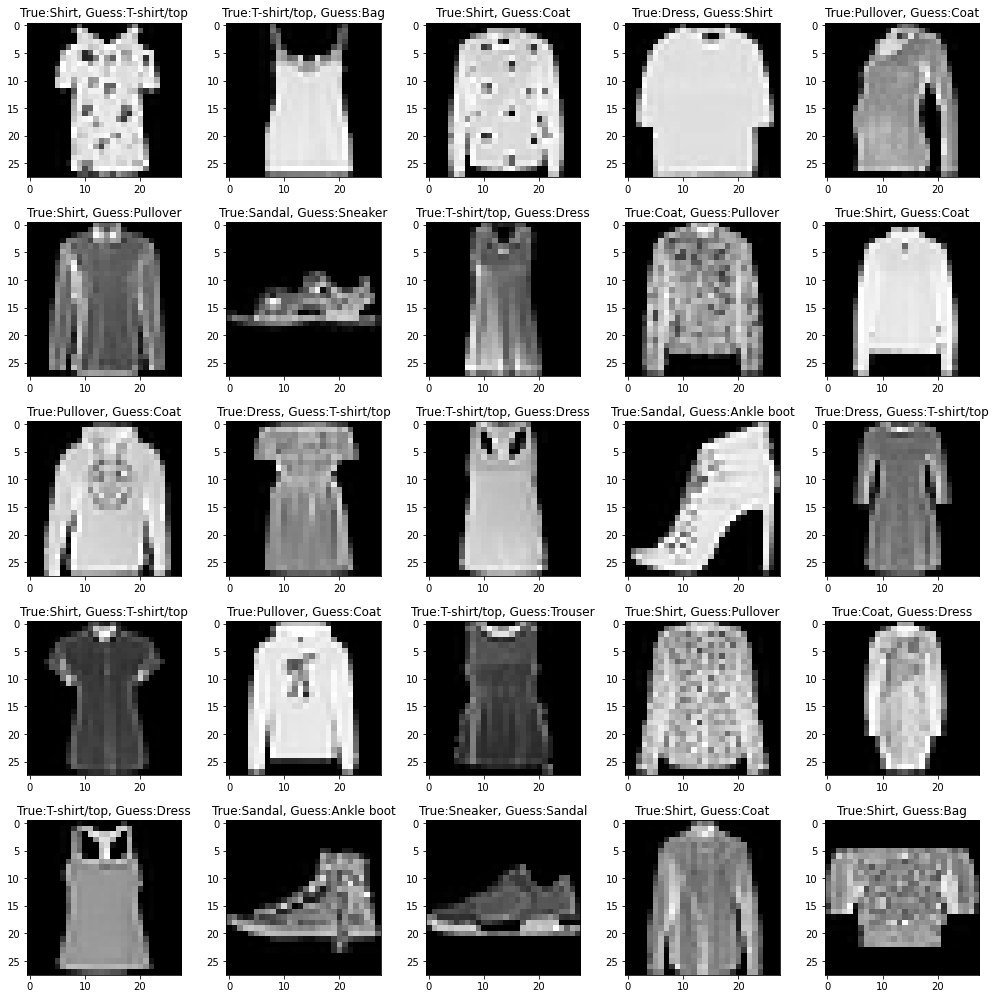

In [18]:
explore_wrong_5x5(train_dataloader, model2, device, class_labels=training_data.classes, seed=12345)